In [1]:
import torch
from torch import nn
import tqdm
import pytorch_lightning
import matplotlib.pyplot as plt

from torch.distributions import Normal

from case_studies.dc2_mdt.utils.simulate_image import ImageSimulator

In [2]:
image_size = 4
add_second_source = True

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self, layers, hidden_ch):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_ch),
            nn.LayerNorm(hidden_ch),
            nn.ReLU(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_ch, hidden_ch),
                    nn.LayerNorm(hidden_ch),
                    nn.ReLU(),
                ) for _ in range(layers)
            ],
            nn.Linear(hidden_ch, 2)
        )
    
    def forward(self, image):
        x = image.flatten(start_dim=1)
        return self.network(x).chunk(2, dim=-1)
    
    def nll(self, image, true_log_fluxes):
        loc, scale = self(image)
        return -1 * Normal(loc, scale.abs() + 1e-5).log_prob(true_log_fluxes)
    
    def sample(self, image, sample_size):
        loc, scale = self(image)
        return Normal(loc, scale.abs() + 1e-5).sample(sample_size)

In [4]:
device = torch.device("cuda:5")
batch_size = 1024
val_batch_size = 2048
training_iters = 10_000
val_iters = 10_000
log_freq = 500
seed = 7272
pytorch_lightning.seed_everything(seed)

Seed set to 7272


7272

In [5]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=1,
                                 min_flux=200.0,
                                 psf_stdev=1.0 if image_size > 1 else 0.1,
                                 background_intensity=100.0).to(device=device)

In [6]:
my_net = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)

In [7]:
def encode_flux(flux: torch.Tensor):
    assert flux.min() > 0.0
    return torch.log1p(flux)

def decode_flux(log_flux: torch.Tensor):
    return torch.expm1(log_flux)

In [8]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size, add_second_source=add_second_source)
    target_fluxes = catalog["fluxes"]  # (b, 1)
    input_image = catalog["images"].unsqueeze(1)  # (b, 1, h, w)
    loss = my_net.nll(input_image, encode_flux(target_fluxes)).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  5%|▌         | 509/10000 [00:07<02:20, 67.71it/s]

[500/10000] loss: 2.785e-01


 10%|█         | 1010/10000 [00:14<02:11, 68.58it/s]

[1000/10000] loss: -6.350e-01


 15%|█▌        | 1512/10000 [00:22<02:02, 69.04it/s]

[1500/10000] loss: -4.899e-01


 20%|██        | 2012/10000 [00:29<01:57, 68.09it/s]

[2000/10000] loss: -7.186e-01


 25%|██▌       | 2513/10000 [00:36<01:50, 67.48it/s]

[2500/10000] loss: 2.085e+00


 30%|███       | 3007/10000 [00:43<01:42, 68.47it/s]

[3000/10000] loss: -3.963e-01


 35%|███▌      | 3513/10000 [00:51<01:38, 65.74it/s]

[3500/10000] loss: -6.666e-01


 40%|████      | 4014/10000 [00:58<01:21, 73.33it/s]

[4000/10000] loss: -7.218e-01


 45%|████▌     | 4510/10000 [01:04<01:15, 73.05it/s]

[4500/10000] loss: -7.027e-01


 50%|█████     | 5008/10000 [01:11<01:06, 74.67it/s]

[5000/10000] loss: -6.965e-01


 55%|█████▌    | 5510/10000 [01:18<01:05, 68.44it/s]

[5500/10000] loss: -7.358e-01


 60%|██████    | 6010/10000 [01:26<00:56, 70.07it/s]

[6000/10000] loss: -7.092e-01


 65%|██████▌   | 6508/10000 [01:33<00:50, 68.70it/s]

[6500/10000] loss: -7.240e-01


 70%|███████   | 7012/10000 [01:40<00:41, 72.62it/s]

[7000/10000] loss: -6.948e-01


 75%|███████▌  | 7510/10000 [01:47<00:34, 72.12it/s]

[7500/10000] loss: -7.206e-01


 80%|████████  | 8014/10000 [01:54<00:27, 72.68it/s]

[8000/10000] loss: -7.110e-01


 85%|████████▌ | 8510/10000 [02:01<00:21, 70.59it/s]

[8500/10000] loss: -6.979e-01


 90%|█████████ | 9011/10000 [02:08<00:13, 72.46it/s]

[9000/10000] loss: -7.248e-01


 95%|█████████▌| 9507/10000 [02:15<00:06, 72.99it/s]

[9500/10000] loss: -7.092e-01


100%|██████████| 10000/10000 [02:21<00:00, 70.50it/s]

[10000/10000] loss: -7.211e-01


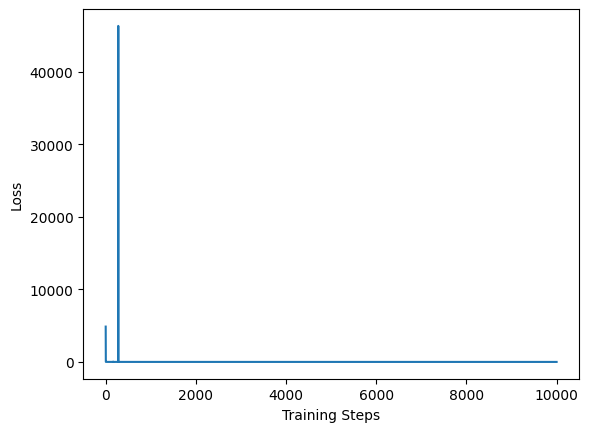

In [9]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

In [10]:
my_net.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                           seed=seed, 
                                           add_second_source=add_second_source)
    target_fluxes = val_catalog["fluxes"]  # (b, 1)
    val_true_fluxes = target_fluxes
    input_image = val_catalog["images"].unsqueeze(1)
    sample = my_net.sample(input_image, sample_size=[val_iters]).squeeze(0)
    val_est_fluxes = decode_flux(sample).cpu()

In [11]:
val_true_fluxes = val_true_fluxes.cpu()

In [12]:
val_true_fluxes.shape

torch.Size([2048, 1])

In [13]:
val_est_fluxes.shape

torch.Size([10000, 2048, 1])

In [14]:
torch.mean((val_true_fluxes - val_est_fluxes) ** 2)

tensor(31152.5176)

In [15]:
torch.mean(torch.abs(val_true_fluxes - val_est_fluxes))

tensor(134.8850)

In [16]:
val_true_fluxes[:10, 0]

tensor([ 473.7338, 1556.4031, 1695.8225, 1812.3633,  456.8997,  855.4359,
        1993.1967, 1269.6095,  232.1797,  265.2233])

In [17]:
val_est_fluxes[0, :10, 0]

tensor([ 590.3365, 1255.9928, 1865.9683, 1633.6138,  480.9793,  834.4349,
        1846.2113, 1487.1448,  301.7213,  265.0631])

In [18]:
# plt.hist(val_est_fluxes.flatten(), color="red", alpha=0.5, density=True)
# plt.hist(val_true_fluxes.flatten(), color="green", alpha=0.5, density=True)
# plt.show()

In [19]:
ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
left_q_points = [(1.0 - c) / 2 for c in ci_cover]
right_q_points = [1.0 - lq for lq in left_q_points]
actual_ci_cover = []
for q in zip(left_q_points, right_q_points):
    q = torch.tensor(q)
    est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)
    above_lower_bound = val_true_fluxes[:, 0] > est_fluxes_q[:, 0, 0]
    below_upper_bound = val_true_fluxes[:, 0] < est_fluxes_q[:, 0, 1]
    actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / val_true_fluxes.shape[0])
actual_ci_cover = torch.stack(actual_ci_cover, dim=0)

In [20]:
actual_ci_cover.shape

torch.Size([19])

In [21]:
actual_ci_cover

tensor([0.0459, 0.1016, 0.1523, 0.2051, 0.2510, 0.2979, 0.3516, 0.3936, 0.4399,
        0.4951, 0.5439, 0.5947, 0.6465, 0.6938, 0.7510, 0.8066, 0.8623, 0.9116,
        0.9551])

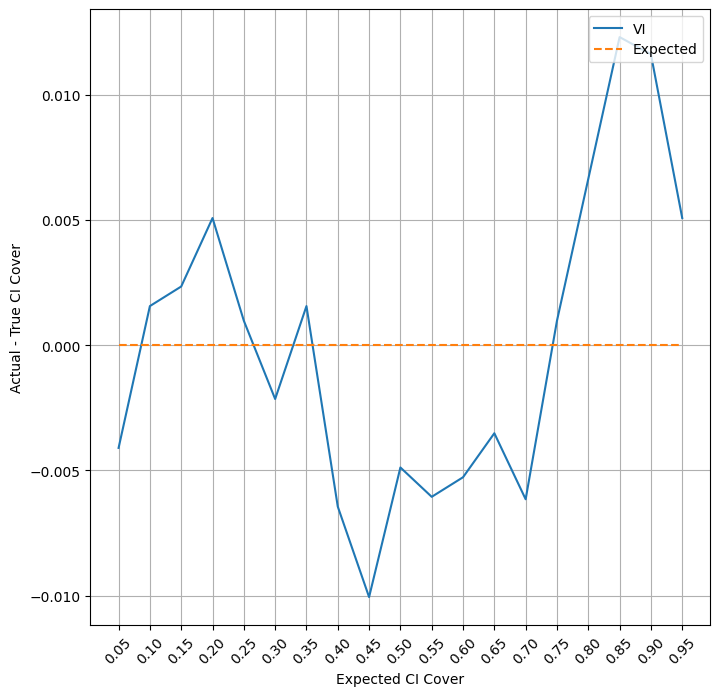

In [22]:
plt.figure(figsize=(8, 8))
a_m_c = actual_ci_cover - ci_cover
plt.plot(ci_cover, a_m_c, label="VI")
plt.plot(ci_cover, torch.zeros_like(ci_cover), linestyle="dashed", label="Expected")
plt.legend(loc="upper right")
plt.grid()
plt.xticks(ci_cover, rotation=45)
plt.xlabel("Expected CI Cover")
plt.ylabel("Actual - True CI Cover")
plt.show()

In [23]:
q = torch.tensor([0.05, 0.95])
est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)

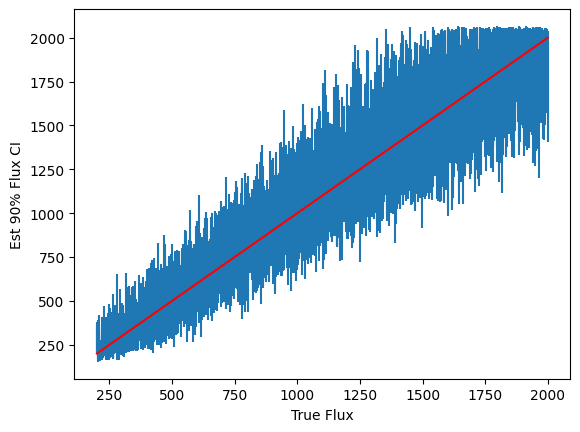

In [24]:
est_fluxes_mean = est_fluxes_q.mean(dim=-1).squeeze(-1)
plt.errorbar(x=val_true_fluxes.flatten(), 
             y=est_fluxes_mean,
             yerr=torch.stack([(est_fluxes_q[:, 0, 0] - est_fluxes_mean).abs(),
                               (est_fluxes_q[:, 0, 1] - est_fluxes_mean).abs()], dim=0),
            fmt="none")
plt.plot([val_true_fluxes.min(), val_true_fluxes.max()], 
         [val_true_fluxes.min(), val_true_fluxes.max()], 
         linestyle="solid", color="red")
plt.xlabel("True Flux")
plt.ylabel("Est 90% Flux CI")
plt.show()